In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation
import random
from utilities import *
from port_trafic_simulation.Example_Models import *


## Port Process Overview

### Arrival at the Port:
- The ship arrives at the port, and the arrival time (`arrival_time`) is recorded.
- The real-world date and time (`real_arrival_time`) is derived from the simulation clock.
- The ship’s type and cargo are identified, and the current size of the berth queues is logged.

### Waiting for Daylight (Night Wait):
- If the ship arrives at night (before 8 AM or after 8 PM), it must wait until 8 AM.
- The wait time until daylight is calculated, and the ship waits for this period.

### Berth Request:
- The ship requests a berth and enters the queue if one is unavailable.
- The function checks meteorological conditions to determine if the ship can proceed.
  
### Meteorological Check (Every 3 Hours):
- Every 3 hours, the meteorological conditions are checked to ensure it's safe for the ship to dock and load.
  
### Waiting Time Calculations:
- Night waiting time (`night_waiting_time`), meteorological check waiting time (`mc_waiting_time`), and berth waiting time (`berth_waiting_time`) are calculated and logged.

### Loading Process:
- **Pre-Service**: Before loading, the ship undergoes a random pre-service wait (`pre_service_time`).
- **Loading**: The ship starts loading once conditions are met. The loading rate is affected by maintenance if it falls within a maintenance period (2/3 of the normal rate).
  - The function simulates loading in time steps (`time_step`), adjusting for weather and storage availability.
  - If forced to depart due to weather, the ship leaves, and a forced departure is logged.
  - If storage is insufficient, the ship waits for a storage refill.
- **Post-Service**: After loading, the ship undergoes a random post-service wait (`post_service_time`).

### Forced Departure:
- If weather conditions deteriorate significantly (forced departure threshold is reached), the ship must leave and wait in the pilot boarding area.
- If the ship is a GPL carrier and sufficiently filled, it may depart without returning to port.

### Departure:
- After loading, the ship releases the berth and departs the port.
- The function logs the entire process, including loading time, waiting time, and total turnaround time (`TAT`), as well as the cargo loaded.
- If a forced departure occurs, it is recorded.

### Maintenance Period:
- During certain periods of the year, one of the three loading arms at the berth undergoes maintenance for 7 random days.
- During maintenance, only two arms are available, and the loading rate is reduced to 2/3 of the normal rate.


In [11]:
Weather = pd.read_excel('Weather_Time_Series.xlsx')


In [12]:
def run_simulation(input_data , capacities , mean_pre_service_time = 3 , mean_post_service_time = 3,
                   weather_data = Weather ,temporary_storage= [80000]
                   , Night_navigation = [False] ,simulation_time = 24 * 366):
    

    env = simpy.Environment()
    channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource
    berth_maintenance = Berth(env)  # Initialize berth maintenance
    stats = Stats()

    sources = []

    types = list(input_data.keys())

    for i , type in enumerate(types):
        products = input_data[type]
        berths = [simpy.Resource(env, capacity=1) for _ in range(capacities[i])]
        storage = Storage(env, temporary_storage=temporary_storage[i])
        p_names = list(products.keys())
        for j , p_name in enumerate(p_names):
            
            production_data = { 
                p_name : products[p_name]
            }

            source = GenerateShips(
                env=env,
                berths=berths,
                berth_maintenance=berth_maintenance,
                channel=channel,
                weather_data=weather_data,  # Ensure Weather is defined or imported
                start_time=start_time,
                mean_pre_service_time=mean_pre_service_time,
                mean_post_service_time=mean_post_service_time,
                stats=stats,
                production_data=production_data,
                storage=storage,
                Night_navigation= Night_navigation[i]
            )
            sources.append(source)
            env.process(source.generate_ships())
    env.run(until=simulation_time)

    
    data = stats.ship_data
    data = pd.DataFrame(data)
    product_names = data['Product_name'].unique()
    volume = [data[data['Product_name'] == product]['cargo_loaded'].sum() for product in product_names]

    occupation_rate = {}
    type_berth_times = {}  # Dictionary to track times by type and berth

    # Initialize type_berth_times
    for product_type in types:
        type_berth_times[product_type] = {}

    # Collect occupation times
    for product_type in types:
        for product in input_data[product_type].keys():
            product_data = data[data['Product_name'] == product]
            
            for berth in product_data['berth occupied'].unique():
                berth_data = product_data[product_data['berth occupied'] == berth]
                occupation_time = berth_data['Port Operation'].apply(time_to_minutes).sum()
                
                if berth not in type_berth_times[product_type]:
                    type_berth_times[product_type][berth] = 0
                type_berth_times[product_type][berth] += occupation_time

    # Calculate occupation rates
    for product_type, berth_times in type_berth_times.items():
        for berth, time in berth_times.items():
            key = f"{product_type}_Berth {berth}"
            occupation_rate[key] = round(time / (60 * 24 * 366), 2)

    

    """occupation_rate = {
    B: round(data[data['berth occupied'] == B]['Port Operation'].apply(time_to_minutes).sum() / (60 * 24) / 366 ,2 )
    for B in data['berth occupied'].unique()
    }"""

    
    cargo_volume_dict = {
    product: round(vol * 1000, 2)
    for product, vol in zip(product_names, volume)
    }


    avg_ships_in_queue = np.mean(stats.queue_sizes["berth_type1"])
    
    system_times = stats.total_times
    system_times_min = [time_to_minutes(time) for time in system_times]
    system_times_hours = [time / 60 for time in system_times_min]
    


    waiting_times = stats.waiting_times
    waiting_times_min = [time_to_minutes(time) for time in waiting_times]
    waiting_times_hours = [time / 60 for time in waiting_times_min]
    
    

    waiting_time_bins = list(range(0, int(max(waiting_times_hours)) + 10, 10))
    total_time_bins = list(range(0, int(max(system_times_hours)) + 20, 20))

    total_time_hist, _ = np.histogram(system_times_hours, bins=total_time_bins)
    waiting_time_hist, _ = np.histogram(waiting_times_hours, bins=waiting_time_bins)


    
    queue_sizes_over_time = stats.queue_sizes["berth_type1"]

    # Collect results from stats
    simulation_results = {
        "occupation_rate": occupation_rate,
        "total_ships_by_type": stats.get_total_ships_by_type(),
        "forced_departures": stats.get_forced_departures(),
        "cargo_volume": cargo_volume_dict,
        "average_kpis": stats.get_average_kpis(),
        "max_kpis": stats.get_max_kpis(),
        "ship_type_kpis": stats.get_ship_type_kpis(),
        "avg_storage": str(round((np.mean(stats.storage) / temporary_storage[0]) * 100 ,2)) + "%",
        "avg ships in queue": round(avg_ships_in_queue,2),
        'waiting_time_bins': waiting_time_bins[:-1],  # Exclude the last bin edge
        'waiting_time_counts': waiting_time_hist.tolist(),
        'total_time_bins': total_time_bins[:-1],
        'total_time_counts': total_time_hist.tolist(),
        'queue_sizes_over_time': queue_sizes_over_time,

    }
    return simulation_results


In [13]:
def final_results(all_results):
    # Organize results into a structured DataFrame
    records = []

    for i, result in enumerate(all_results, 1):
        scenario_label = f"Scenario {i}"
        
        # 1. Occupation Rate
        for key, value in result['occupation_rate'].items():
            product = key
            kpi_name = f"Occupation Rate.{product}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 2. Total Ships by Type
        for ship_type, count in result['total_ships_by_type'].items():
            kpi_name = f"Total Ships by Type.{ship_type}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': count})
        
        # 3. Forced Departures
        kpi_name = 'Forced Departures'
        records.append({'KPI Name': kpi_name, f'Scenario {i} Value': result['forced_departures']})
        
        # 4. Cargo Volume
        # Assuming the order of cargo_volume corresponds to products sorted alphabetically
        unique_products = sorted(set([k.split()[0] for k in result['cargo_volume'].keys()]))
        # Create records for each product's volume
        for product in unique_products:
            kpi_name = f"Cargo Volume.{product}"
            volume = result['cargo_volume'][product]
            print(f"product {product} , volume {volume}")
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': volume})
        
        # 5. Average KPIs
        for kpi, value in result['average_kpis'].items():
            kpi_name = f"Average KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 6. Max KPIs
        for kpi, value in result['max_kpis'].items():
            kpi_name = f"Max KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 7. Ship Type KPIs
        for ship_type, kpis in result['ship_type_kpis'].items():
            for kpi, value in kpis.items():
                kpi_name = f"Ship Type KPIs.{ship_type}.{kpi}"
                records.append({'KPI Name': kpi_name, f'Scenario {i} Value': value})
        
        # 8. Avg Storage
        kpi_name = 'Average Storage'
        records.append({'KPI Name': kpi_name, f'Scenario {i} Value': result['avg_storage']})
        
        # 9. Avg Ships in Queue
        kpi_name = 'Average Ships in Queue'
        records.append({'KPI Name': kpi_name, f'Scenario {i} Value': result['avg ships in queue']})

    # Convert list of dictionaries to DataFrame
    df_results = pd.DataFrame(records)

    # Pivot the DataFrame to have one row per KPI Name and separate columns for each scenario's values
    df_pivot = df_results.pivot_table(index='KPI Name', 
                                    columns=[col for col in df_results.columns if col.startswith('Scenario')],
                                    values='Scenario 1 Value')

    # A better approach is to pivot on 'Scenario' labels
    # Reconstruct the DataFrame with 'Scenario' as a column

    # Reset the 'records' list to include 'Scenario' as a separate column
    records = []

    for i, result in enumerate(all_results, 1):
        scenario_label = f"Scenario {i}"
        
        # 1. Occupation Rate
        for key, value in result['occupation_rate'].items():
            product = key
            kpi_name = f"Occupation Rate.{product}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 2. Total Ships by Type
        for ship_type, count in result['total_ships_by_type'].items():
            kpi_name = f"Total Ships by Type.{ship_type}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': count})
        
        # 3. Forced Departures
        kpi_name = 'Forced Departures'
        records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': result['forced_departures']})
        
        # 4. Cargo Volume
        # Get unique products from cargo_volume dictionary
        unique_products = sorted(result['cargo_volume'].keys())

        # Create records for each product's volume
        for product in unique_products:
            kpi_name = f"Cargo Volume.{product}"
            volume = result['cargo_volume'][product]
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': volume})
        
        # 5. Average KPIs
        for kpi, value in result['average_kpis'].items():
            kpi_name = f"Average KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 6. Max KPIs
        for kpi, value in result['max_kpis'].items():
            kpi_name = f"Max KPIs.{kpi}"
            records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 7. Ship Type KPIs
        for ship_type, kpis in result['ship_type_kpis'].items():
            for kpi, value in kpis.items():
                kpi_name = f"Ship Type KPIs.{ship_type}.{kpi}"
                records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': value})
        
        # 8. Avg Storage
        kpi_name = 'Average Storage'
        records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': result['avg_storage']})
        
        # 9. Avg Ships in Queue
        kpi_name = 'Average Ships in Queue'
        records.append({'KPI Name': kpi_name, 'Scenario': scenario_label, 'Value': result['avg ships in queue']})

    # Create DataFrame
    df_all = pd.DataFrame(records)

    # Pivot to have one row per KPI Name and separate columns for each scenario's values
    df_final = df_all.pivot(index='KPI Name', columns='Scenario', values='Value').reset_index()

    # Rename columns for clarity
    df_final.columns.name = None  # Remove the hierarchy
    df_final.rename(columns={
        'Scenario 1': 'Scenario 1 Value',
        'Scenario 2': 'Scenario 2 Value'
    }, inplace=True)

    # Display the DataFrame
    return df_final

In [14]:
np.random.seed(0)

# Define your classes here or import them if they are defined elsewhere
# from your_module import Storage, Berth, Stats, GenerateShips, Weather

# Parameters
mean_pre_service_time = 3  # Average pre-service time in minutes
mean_post_service_time = 3  # Average post-service time in minutes

simulation_time = 24 * 366  # Simulate for 366 days
start_time = datetime.strptime("00:00:00", "%H:%M:%S")

# Define fleet compositions
fleet_composition15_1 = {
    'A': {'Capacity': 15000, 'Composition': 0.3, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.5, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.1, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.1, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition15_2 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.2, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.2, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.6, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition75_1 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.4, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.1, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition75_2 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1200, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0, 'Loading Rate (T/h)': 1500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.2, 'Loading Rate (T/h)': 2000, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.8, 'Loading Rate (T/h)': 2200, 'LOA (m)': 300}
}
fleet_composition75_3 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.4, 'Loading Rate (T/h)': 2000, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 2800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.1, 'Loading Rate (T/h)': 4200, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 4200, 'LOA (m)': 300}
}
fleet_composition300_1 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.1, 'Loading Rate (T/h)': 2000, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 2800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.4, 'Loading Rate (T/h)': 4200, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 4200, 'LOA (m)': 300}
}

fleet_composition300_2 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0, 'Loading Rate (T/h)': 2000, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.0, 'Loading Rate (T/h)': 2800, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.2, 'Loading Rate (T/h)': 4200, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.8, 'Loading Rate (T/h)': 4200, 'LOA (m)': 300}
}
fleet_composition300_3 = {
    'A': {'Capacity': 15000, 'Composition': 0, 'Loading Rate (T/h)': 1800, 'LOA (m)': 144},
    'B': {'Capacity': 25000, 'Composition': 0.1, 'Loading Rate (T/h)': 2500, 'LOA (m)': 180},
    'C': {'Capacity': 35000, 'Composition': 0.5, 'Loading Rate (T/h)': 3300, 'LOA (m)': 196},
    'D': {'Capacity': 50000, 'Composition': 0.4, 'Loading Rate (T/h)': 4700, 'LOA (m)': 255},
    'E': {'Capacity': 80000, 'Composition': 0.0, 'Loading Rate (T/h)': 4700, 'LOA (m)': 300}
}


# Production data as a dictionary with fleet compositions
production_data75_1 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition75_1}
}
production_data15_1 = {
    'Solide': {'Composition': 1, 'Production per Year': 1_500_000, 'Fleet Composition': fleet_composition15_1}
}
production_data15_2 = {
    'Liquide': {'Composition': 1, 'Production per Year': 1_500_000, 'Fleet Composition': fleet_composition15_2}
}
production_data75_2 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition75_2}
}
production_data75_3 = {
    'Solide': {'Composition': 1, 'Production per Year': 7_500_000, 'Fleet Composition': fleet_composition75_3}
}
production_data300_1 = {
    'Solide': {'Composition': 1, 'Production per Year': 30_000_000, 'Fleet Composition': fleet_composition300_1}
}
production_data300_2 = {
    'Solide': {'Composition': 1, 'Production per Year': 30_000_000, 'Fleet Composition': fleet_composition300_2}
}
production_data300_3 = {
    'Solide': {'Composition': 1, 'Production per Year': 30_000_000, 'Fleet Composition': fleet_composition300_3}
}

production_data = [production_data15_1 , production_data15_2 , production_data75_1 , production_data75_1, production_data75_1, production_data75_1 , production_data75_2, production_data75_3 , production_data300_1 , production_data300_1 , production_data300_1, production_data300_1  , production_data300_2 , production_data300_3]

temporary_storage = [200_000 , 100_000]
Night_navigation = [False , True] 

In [15]:
input_data = {
    'Solid' :{
        'Phosphate': {'Composition': 1, 'Production per Year': 1_500_000, 'Fleet Composition': fleet_composition15_1} ,
        'Urea': {'Composition': 1, 'Production per Year': 3_500_000, 'Fleet Composition': fleet_composition15_2}
    },

    'Liquide' :{
        'Gas': {'Composition': 1, 'Production per Year': 1_500_000, 'Fleet Composition': fleet_composition15_1}
    }
}



input_data = {
    'Liquide' :{
        'Gas': {'Composition': 1, 'Production per Year': 30_000_000, 'Fleet Composition': fleet_composition300_2}
    }
}


results = run_simulation(input_data , [4] ,temporary_storage= [175_000] , Night_navigation= [False])

In [17]:
test = final_results([results])

product Gas , volume 30293000.0


In [ ]:
p = test[test['KPI Name'] == 'Cargo Volume.Gas']

,KPI Name,Scenario 1 Value
8,Cargo Volume.Gas,30293000.0


In [19]:
results = final_results([results])
results["KPI Name"] = results["KPI Name"].str.replace(" ", "_")
results

product Gas , volume 30293000.0


,KPI Name,Scenario 1 Value
0,Average_KPIs.avg_Port_Operation,28:15
1,Average_KPIs.avg_berth_waiting_time,1:52
2,Average_KPIs.avg_mc_waiting_time,1:06
3,Average_KPIs.avg_storage_waiting_time,4:36
4,Average_KPIs.avg_total_time,39:05
5,Average_KPIs.avg_waiting_time,2:58
6,Average_Ships_in_Queue,0.13
7,Average_Storage,46.47%
8,Cargo_Volume.Gas,30293000.0
9,Forced_Departures,0


In [ ]:
np.random.seed(0)
temporarys = [140_000, 140_000, 375_000 , 375_000 , 375_000 , 420_000, 375_000 , 375_000 , 600_000 , 600_000 , 600_000 , 700_000 , 600_000 , 600_000]
capcitys = [1 , 1 , 2 , 3 , 2 , 2 , 2 ,2 , 5 , 6 , 5 , 5 , 5 , 5]
Night_navigation = [False , False ,
                    False , False , True, False , False , False 
                    , False , False , True , False , False , False]
all_results = [] 
for temporar, P ,capacity , night in zip(temporarys , production_data , capcitys , Night_navigation):
    results = run_simulation([capacity,0], [P],temporary_storage= [temporar] , Night_navigation= [night])
    
    all_results.append(results)

In [219]:
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ,'Scenario 3' , 'Scenario 4' , 'Scenario 5' , 'Scenario 6' , 'Scenario 7' , 'Scenario 8' , 'Scenario 9' , 'Scenario 10' , 'Scenario 11' , 'Scenario 12' , 'Scenario 13' , 'Scenario 14']]
Max_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_waiting_time']
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_storage_waiting_time']
cargo_volume = matrix[matrix['KPI Name']=='Cargo Volume.Solide']
storage_waiting_time 

,KPI Name,Scenario 1 Value,Scenario 2 Value,Scenario 3,Scenario 4,Scenario 5,Scenario 6,Scenario 7,Scenario 8,Scenario 9,Scenario 10,Scenario 11,Scenario 12,Scenario 13,Scenario 14
3,Average KPIs.avg_storage_waiting_time,4:00,4:12,2:08,2:04,2:06,1:47,4:39,2:07,1:38,1:36,1:36,1:25,2:59,1:37


In [220]:
matrix.to_csv('Scenarios.csv')

## Average waiting time caused by temporar storage VS temporar storage capcity

C:\Users\mohammed\AppData\Local\Temp\ipykernel_8724\774114169.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


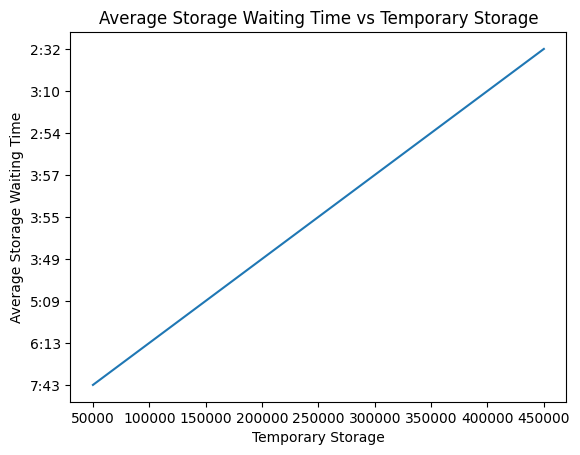

In [118]:
temporarys = [50_000 * i for i in range(1,10)]
all_results = []
for tempo in temporarys:
    results = run_simulation([5], [production_data300_1],temporary_storage= [tempo] , Night_navigation= [False])
    all_results.append(results)
columns = ['Scenario '+str(i) for i in range(3,10)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]+columns]
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_storage_waiting_time']
storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
plt.plot(temporarys , storage_waiting_time.T[3])
plt.xlabel('Temporary Storage')
plt.ylabel('Average Storage Waiting Time')
plt.title('Average Storage Waiting Time vs Temporary Storage')
plt.show()


C:\Users\mohammed\AppData\Local\Temp\ipykernel_18600\3738327318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


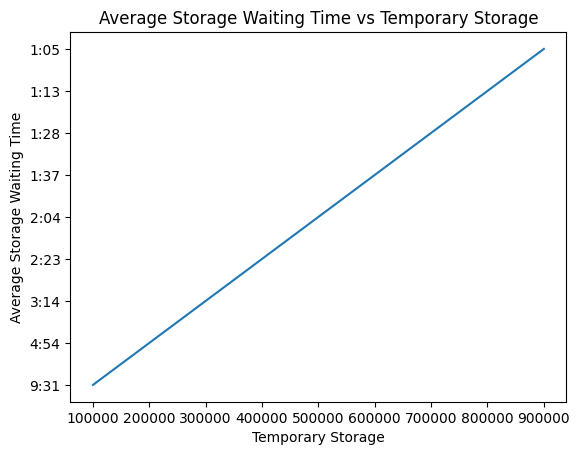

In [251]:
temporarys = [100_000 * i for i in range(1,10)]
all_results = []
for tempo in temporarys:
    results = run_simulation([6,0], [production_data300_1],temporary_storage= [tempo] , Night_navigation= [False])
    all_results.append(results)

columns = ['Scenario '+str(i) for i in range(3,10)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]+columns]
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_storage_waiting_time']
storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
plt.plot(temporarys , storage_waiting_time.T[3])
plt.xlabel('Temporary Storage')
plt.ylabel('Average Storage Waiting Time')
plt.title('Average Storage Waiting Time vs Temporary Storage')
plt.show()

## Average berth wiating time VS number of berths

C:\Users\mohammed\AppData\Local\Temp\ipykernel_18600\74008807.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


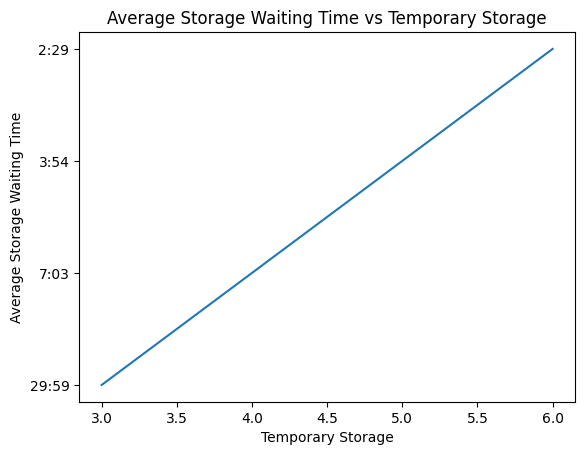

In [256]:
caps = [3, 4,  5 , 6]
all_results = []
for cap in caps:
    results = run_simulation([cap,0], [production_data300_1],temporary_storage= [300_000] , Night_navigation= [False])
    all_results.append(results)

columns = ['Scenario '+str(i) for i in range(3,5)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]+columns]
storage_waiting_time = matrix[matrix['KPI Name']=='Average KPIs.avg_berth_waiting_time']
storage_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
plt.plot(caps , storage_waiting_time.T[1])
plt.xlabel('Temporary Storage')
plt.ylabel('Average Storage Waiting Time')
plt.title('Average Storage Waiting Time vs Temporary Storage')
plt.show()

## Night Navigation vs Max Waiting time

C:\Users\mohammed\AppData\Local\Temp\ipykernel_18600\3214243042.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)


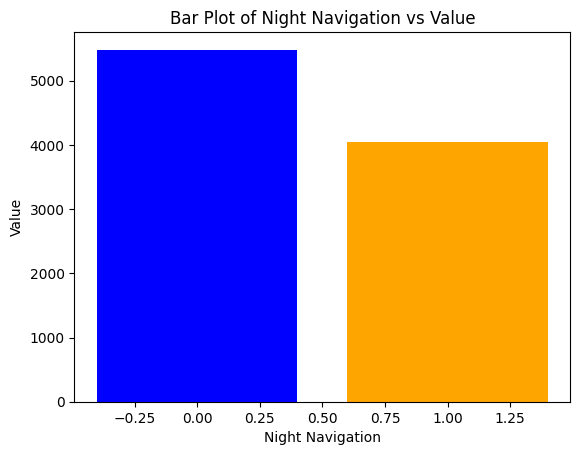

In [275]:
Night = [False , True]
all_results = []
for night in Night:
    results = run_simulation([6,0], [production_data300_1],temporary_storage= [300_000] , Night_navigation= [night])
    all_results.append(results)

columns = ['Scenario '+str(i) for i in range(3,5)]
matrix = final_results(all_results)[['KPI Name','Scenario 1 Value' , 'Scenario 2 Value' ]]
max_waiting_time = matrix[matrix['KPI Name']=='Max KPIs.max_waiting_time']
max_waiting_time.drop('KPI Name' , axis = 1 , inplace = True)
waiting = [time_to_minutes(time) for time in max_waiting_time.T[14]]

# Create the bar plot
plt.bar(Night, waiting, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Night Navigation')
plt.ylabel('Value')
plt.title('Bar Plot of Night Navigation vs Value')

# Show the plot
plt.show()

In [14]:
from flask import Flask, render_template, request, redirect, url_for, flash 
from flask import send_file
import os
from datetime import datetime

app = Flask(__name__)
app.secret_key = 'your_secure_secret_key'  # Replace with a secure key in production


def construct_fleet_composition(capacitys, compositions, loading_rates, loas):
    fleet_composition = {}
    
    number_of_vessels = 5  # Fixed ship types A, B, C, D, E
    vessel_names = ['A', 'B', 'C', 'D', 'E']
    for i in range(number_of_vessels):
        name = vessel_names[i]
        capacity = capacitys[i]
        composition = compositions[i]
        loading_rate = loading_rates[i]
        loa = loas[i]
        
        fleet_composition[name] = {
            'Capacity': capacity,
            'Composition': composition,
            'Loading Rate (T/h)': loading_rate,
            'LOA (m)': loa
        }
    
    return fleet_composition

def construct_fleet_product_data(capacitys, compositions, loading_rates, loas, product_name, production_per_year=3_000_000):
    fleet_composition = construct_fleet_composition(capacitys, compositions, loading_rates, loas)
    
    product_data = {
        product_name: {
            'Composition': 1,  # Fixed composition for simplicity
            'Production per Year': production_per_year,
            'Fleet Composition': fleet_composition
        }
    }
    
    return product_data

def construct_input_data(input_data,product_type ,  product_data):
    product_name = list(product_data.keys())[0]
    input_data[product_type][product_name] = product_data[product_name]
    return input_data

@app.route('/')
def index():
    # Define fixed ship types to pass to the template
    fixed_ship_types = ['A', 'B', 'C', 'D', 'E']
    return render_template('index.html', fixed_ship_types=fixed_ship_types)

@app.route('/run_simulation', methods=['POST'])
def run_simulation_route():
    try:
        # Initialize list for products
        products = []

        # Extract product numbers based on form keys
        product_numbers = sorted(
            set([
                key.replace('product', '').replace('_name', '') 
                for key in request.form.keys() 
                if key.startswith('product') and key.endswith('_name')
            ]), 
            key=lambda x: int(x)
        )

        if not product_numbers:
            flash('No products found. Please add at least one product.')
            return redirect(url_for('index'))

        # Define fixed ship types
        fixed_ship_types = ['A', 'B', 'C', 'D', 'E']

        berth_capacitys = []
        temporary_storages = []
        Night_navigations = []

        productions = []
        product_types = []
        p_links = {}
        for prod_num in product_numbers:
            # Retrieve product-specific data
            product_name = request.form.get(f'product{prod_num}_name')
            product_type = request.form.get(f'product{prod_num}_type')
            try:
                #composition = float(request.form.get(f'product{prod_num}_composition', 0))
                capacity = int(request.form.get(f'product{prod_num}_number_of_berths', 0))
                temporary_storage = int(request.form.get(f'product{prod_num}_temporary_storage', 100_000))
                production_per_year = int(request.form.get(f'product{prod_num}_production_per_year', 0))
            except ValueError:
                flash(f'Invalid numerical input for product {prod_num}. Please enter valid numbers.')
                return redirect(url_for('index'))

            night_navigation = f'product{prod_num}_Night_navigation' in request.form

            berth_capacitys.append(capacity)
            temporary_storages.append(temporary_storage)
            Night_navigations.append(night_navigation)
            productions.append(production_per_year)

            ship_capacitys = []
            ship_compositions = []
            ship_loading_rates = []
            ship_loas = []


            for ship_type in fixed_ship_types:
                # Construct form field names for each ship attribute
                ship_capacity_field = f'product{prod_num}_ship{ship_type}_capacity'
                ship_composition_field = f'product{prod_num}_ship{ship_type}_composition'
                ship_loading_rate_field = f'product{prod_num}_ship{ship_type}_loading_rate'
                ship_loa_field = f'product{prod_num}_ship{ship_type}_loa'

                # Retrieve ship-specific data entered by user
                try:
                    ship_capacity = int(request.form.get(ship_capacity_field, 0))
                    ship_composition = float(request.form.get(ship_composition_field, 0))
                    ship_loading_rate = int(request.form.get(ship_loading_rate_field, 0))
                    ship_loa = int(request.form.get(ship_loa_field, 0))
                    ship_capacitys.append(ship_capacity)
                    ship_compositions.append(ship_composition)
                    ship_loading_rates.append(ship_loading_rate)
                    ship_loas.append(ship_loa)
                except ValueError:
                    flash(f'Invalid input for ship {ship_type} in product {prod_num}. Please enter valid numbers.')
                    return redirect(url_for('index'))

            # Construct product data based on user input
            product_data = construct_fleet_product_data(
                ship_capacitys, ship_compositions, ship_loading_rates, ship_loas, product_name, production_per_year
            )

            products.append(product_data)
            product_types.append(product_type)
            p_links[product_type] = product_data
            
        product_types_unique = list(set(product_types))

        input_data = {
            product_type: {} for product_type in product_types_unique
        }
        
        for product_data , product_type in zip(products , product_types):
            input_data = construct_input_data(input_data,product_type ,product_data)

            
        
        print(input_data)
        # Run the simulation with the collected products and their ships
        simulation_results = run_simulation( input_data,berth_capacitys,
                                            temporary_storage= temporary_storages,
                                            Night_navigation= Night_navigations,    
        )

        #print(simulation_results)  # For debugging purposes

        # Pass the simulation results to the 'result.html' template
        return render_template('result.html', result=simulation_results)

    except Exception as e:
        # Handle exceptions by flashing an error message and redirecting to the index
        flash(f'An error occurred: {str(e)}')
        return redirect(url_for('index'))

# Helper functions (already implemented)
def get_ship_capacity(ship_type):
    """Retrieve ship capacity based on ship type."""
    capacities = {
        'A': 15000,
        'B': 25000,
        'C': 35000,
        'D': 50000,
        'E': 80000
    }
    return capacities.get(ship_type, 0)

def get_loading_rate(ship_type):
    """Retrieve loading rate based on ship type."""
    loading_rates = {
        'A': 1200,
        'B': 1500,
        'C': 1800,
        'D': 2200,
        'E': 2400
    }
    return loading_rates.get(ship_type, 0)

def get_loa(ship_type):
    """Retrieve LOA (Length Overall) based on ship type."""
    loa_values = {
        'A': 144,
        'B': 180,
        'C': 196,
        'D': 255,
        'E': 300
    }
    return loa_values.get(ship_type, 0)

@app.route('/download_results')
def download_results():
    # Send the CSV file as an attachment.
    filepath = '2025_simulation.csv'
    if os.path.exists(filepath):
        return send_file(filepath, 
                         as_attachment=True,  
                         mimetype='text/csv')
    else:
        return "No results file found.", 404

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [26/Dec/2024 13:02:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2024 13:02:47] "GET /favicon.ico HTTP/1.1" 404 -


In [21]:
def construct_fleet_composition(capacitys , compositions , loading_rates , loas):
    fleet_composition = {}
    
    number_of_vessels = 5  # Assuming 5 fixed ship types A, B, C, D, E
    vessel_names = ['A', 'B', 'C', 'D', 'E']
    for i in range(number_of_vessels):
        name = vessel_names[i]
        capacity = capacitys[i]
        composition = compositions[i]
        loading_rate = loading_rates[i]
        loa = loas[i]
        
        fleet_composition[name] = {
            'Capacity': capacity,
            'Composition': composition,
            'Loading Rate (T/h)': loading_rate,
            'LOA (m)': loa
        }

    
    return fleet_composition

def construct_fleet_product_data(capacitys , compositions , loading_rates , loas , product_name , production_per_year = 3_000_000):
    fleet_composition = construct_fleet_composition(capacitys , compositions , loading_rates , loas)
    
    product_data = {
        product_name: {
            'Composition': 1,  # Assuming a fixed composition for simplicity
            'Production per Year': production_per_year,  # Assuming a fixed production value
            'Fleet Composition': fleet_composition
        }
    }
    
    return product_data


def construct_input_data(input_data,product_type ,  product_data):
    product_name = list(product_data.keys())[0]
    input_data[product_type][product_name] = product_data[product_name]
    return input_data
    

# Example usage:
capacitys = [15000, 25000, 35000, 50000, 80000]
compositions = [0.3, 0.5, 0.1, 0.1, 0.0]
loading_rates = [1200, 1500, 1800, 2000, 2200]
loas = [144, 180, 196, 255, 300]

product_types = ['Solide', 'Liquide']
input_data = {
    product_types[0]: {},
    product_types[1]: {}
}

for i in range(1, 2):
    product_name = f'Product {i}'
    product_data = construct_fleet_product_data(capacitys, compositions, loading_rates, loas, product_name)
    input_data = construct_input_data(input_data , 'Solide' , product_data)
    input_data = construct_input_data(input_data , 'Liquide' , product_data)

